In [1]:
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

import dask

In [2]:
# Champaign County
lat, lon = 40.24854232214424, -88.27057681750155

In [24]:
# Get growing season
gs = xr.open_dataset("/gpfs/group/kaf26/default/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/wbm/wbm_spool/flowdirection206_us/CDL-US-M_nonrice_irr_Kc_av_hist/2014.nc")
gs = gs.sel(lat=lat, lon=lon, method="nearest").MC_nonrice_irr_Kc_av.to_numpy() > 0.

## Preliminaries

In [3]:
# Paths
wbm_path = "/gpfs/group/kaf26/default/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/wbm"

In [4]:
# Read function
def read_nc(ensemble, model, member, method, ssp, year, var_id, coords, wbm_path):
    # LOCA projections split into 3 runs
    if ensemble == "LOCA2":
        if ssp == "historical":
            ssp_time = "historical"
        elif year < 2045:
            ssp_time = f"{ssp}_early"
        elif year < 2075:
            ssp_time = f"{ssp}_mid"
        else:
            ssp_time = f"{ssp}_late"
    else:
        ssp_time = ssp

    # OakRidge method
    if ensemble == "OakRidge":
        member_method = f"{member}_{method}"
    else:
        member_method = member
        
    # WBM output or spool
    if var_id in ["soilMoistFrac", "soilMoist"]:
        ds = xr.open_dataset(f"{wbm_path}/{ensemble}_{model}_{member_method}_{ssp_time}/wbm_output/daily/wbm_{str(year)}.nc")#, decode_times=False)
    else:
        if ensemble == "OakRidge":
            if var_id in ["tasmax", "tasmin"]:
                var_id_fixed = var_id.replace("as","")
        else:
            var_id_fixed = var_id
        ds = xr.open_dataset(f"{wbm_path}/wbm_spool/flowdirection206_us/{ensemble}_{model}_{member_method}_{ssp_time}_{var_id_fixed}_daily/{str(year)}.nc")#, decode_times=False)
        
    # Update details
    ds = ds.assign_coords(model = model)
    ds = ds.assign_coords(ssp = ssp)
    if var_id in ["tasmax", "tasmin"]:
        ds = ds.rename({var_id_fixed:var_id})
    if ensemble == "OakRidge":
        ds = ds.assign_coords(method = f"OKR_{method}")
    else:
        ds = ds.assign_coords(method = ensemble)
    # Select gridpoint if desired
    if coords:
        df = ds.sel(lat=coords[0], lon=coords[1], method="nearest").to_dataframe().reset_index().drop(columns=["crs","lat","lon"])
        return df
    else:
        return ds

In [5]:
############
### Dask ###
############
from dask_jobqueue import PBSCluster

cluster = PBSCluster(
    cores=1,
    resource_spec="pmem=10GB",
    memory="10GB",
    worker_extra_args=["#PBS -l feature=rhel7"],
    walltime="00:10:00"
)

cluster.scale(jobs=10)  # ask for jobs

from dask.distributed import Client

client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.102.201.238:33674,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Soil Moisture

## Historical

In [25]:
# Get run paths
ssp = "historical"

obs_paths = glob.glob(f"{wbm_path}/OBS_*")
nex_paths = glob.glob(f"{wbm_path}/NEX-GDDP_*{ssp}*")
loca_paths = glob.glob(f"{wbm_path}/LOCA2_*{ssp}*")
okr_paths = glob.glob(f"{wbm_path}/OakRidge_*{ssp}*")

In [29]:
# Loop through all
year = 1986

df_out = []

# LOCA
for path in loca_paths:
    # Read
    ds = xr.open_dataset(f"{path}/wbm_output/daily/wbm_{str(year)}.nc", decode_times=False)
    df = ds.sel(lat=lat, lon=lon, method="nearest").to_dataframe()[["soilMoistFrac"]].reset_index()
    df["model"] = path.split("_")[-3]
    df["ensemble"] = "LOCA"
    df["method"] = "LOCA_Livneh"
    df["ssp"] = ssp
    # Append
    df_out.append(df)
    
# OakRidge
for path in okr_paths:
    # Read
    ds = xr.open_dataset(f"{path}/wbm_output/daily/wbm_{str(year)}.nc", decode_times=False)
    df = ds.sel(lat=lat, lon=lon, method="nearest").to_dataframe()[["soilMoistFrac"]].reset_index()
    df["model"] = path.split("_")[-5]
    df["ensemble"] = "OakRidge"
    df["method"] = f"{path.split('_')[-3]}_{path.split('_')[-2]}"
    df["ssp"] = ssp
    # Append
    df_out.append(df)
    
# NEX
for path in nex_paths:
    # Read
    ds = xr.open_dataset(f"{path}/wbm_output/daily/wbm_{str(year)}.nc", decode_times=False)
    df = ds.sel(lat=lat, lon=lon, method="nearest").to_dataframe()[["soilMoistFrac"]].reset_index()
    df["model"] = path.split("_")[-3]
    df["ensemble"] = "NEX-GDDP"
    df["method"] = "BCSD_GMFD"
    df["ssp"] = ssp
    # Append
    df_out.append(df)

In [30]:
# All
df = pd.concat(df_out)

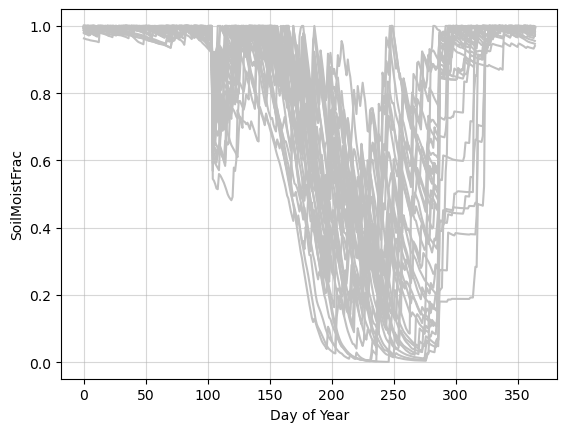

In [31]:
# Plot
fig, ax = plt.subplots()
ax.set_title("")
ax.grid(alpha=0.5)

for ensemble in df.ensemble.unique():
    df_ens = df[df.ensemble == ensemble]
    for model in df_ens.model.unique():
        if ensemble in ["LOCA", "NEX-GDDP"]:
            ax.plot(df_ens[df_ens.model == model]["soilMoistFrac"], color="silver")
        elif ensemble == "OakRidge":
            for method in df_ens[df_ens.model == model].method.unique():
                ax.plot(df_ens[(df_ens.model == model) & (df_ens.method == method)]["soilMoistFrac"], color="silver")

ax.set_ylabel("SoilMoistFrac")
ax.set_xlabel("Day of Year")
plt.show()

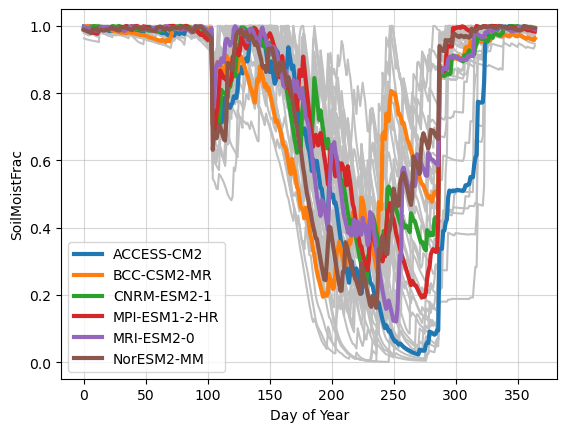

In [32]:
# Plot model means
fig, ax = plt.subplots()
ax.set_title("")
ax.grid(alpha=0.5)

# Add model means
df_model_means = df.groupby(["model","time"])[["soilMoistFrac"]].mean().reset_index()
for model in df_model_means.model.unique():
    ax.plot(np.arange(365),
            df_model_means[df_model_means.model == model]["soilMoistFrac"],
            label=model,
            lw=3,
            zorder=10)
    
ax.legend()

for ensemble in df.ensemble.unique():
    df_ens = df[df.ensemble == ensemble]
    for model in df_ens.model.unique():
        if ensemble in ["LOCA", "NEX-GDDP"]:
            ax.plot(df_ens[df_ens.model == model]["soilMoistFrac"], color="silver")
        elif ensemble == "OakRidge":
            for method in df_ens[df_ens.model == model].method.unique():
                ax.plot(df_ens[(df_ens.model == model) & (df_ens.method == method)]["soilMoistFrac"], color="silver")

ax.set_ylabel("SoilMoistFrac")
ax.set_xlabel("Day of Year")
plt.show()

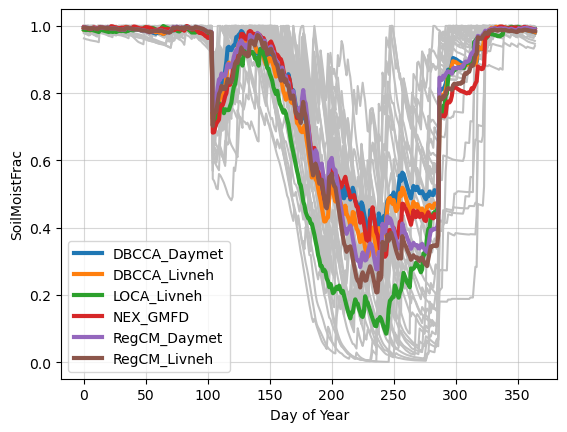

In [33]:
# Plot model means
fig, ax = plt.subplots()
ax.set_title("")
ax.grid(alpha=0.5)

# Add method means
df_method_means = df.groupby(["method","time"])[["soilMoistFrac"]].mean().reset_index()
for method in df_method_means.method.unique():
    ax.plot(np.arange(365),
            df_method_means[df_method_means.method == method]["soilMoistFrac"],
            label=method,
            lw=3,
            zorder=10)
    
ax.legend()

for ensemble in df.ensemble.unique():
    df_ens = df[df.ensemble == ensemble]
    for model in df_ens.model.unique():
        if ensemble in ["LOCA", "NEX-GDDP"]:
            ax.plot(df_ens[df_ens.model == model]["soilMoistFrac"], color="silver")
        elif ensemble == "OakRidge":
            for method in df_ens[df_ens.model == model].method.unique():
                ax.plot(df_ens[(df_ens.model == model) & (df_ens.method == method)]["soilMoistFrac"], color="silver")

ax.set_ylabel("SoilMoistFrac")
ax.set_xlabel("Day of Year")
plt.show()

## SSP5-8.5

In [37]:
# Get run paths
ssp = "ssp585"

obs_paths = glob.glob(f"{wbm_path}/OBS_*")
nex_paths = glob.glob(f"{wbm_path}/NEX-GDDP_*{ssp}*")
loca_paths = glob.glob(f"{wbm_path}/LOCA2_*{ssp}*")
okr_paths = glob.glob(f"{wbm_path}/OakRidge_*{ssp}*")

In [49]:
# Loop through all
year = 2050
loca_time = "mid"

df_out = []

# LOCA
for path in loca_paths:
    if path.split("_")[-1] == loca_time:
        # Read
        ds = xr.open_dataset(f"{path}/wbm_output/daily/wbm_{str(year)}.nc", decode_times=False)
        df = ds.sel(lat=lat, lon=lon, method="nearest").to_dataframe()[["soilMoistFrac"]].reset_index()
        df["model"] = path.split("_")[-4]
        df["ensemble"] = "LOCA"
        df["method"] = "LOCA_Livneh"
        df["ssp"] = ssp
        # Append
        df_out.append(df)

# NEX
for path in nex_paths:
    # Read
    ds = xr.open_dataset(f"{path}/wbm_output/daily/wbm_{str(year)}.nc", decode_times=False)
    df = ds.sel(lat=lat, lon=lon, method="nearest").to_dataframe()[["soilMoistFrac"]].reset_index()
    df["model"] = path.split("_")[-3]
    df["ensemble"] = "NEX-GDDP"
    df["method"] = "BCSD_GMFD"
    df["ssp"] = ssp
    # Append
    df_out.append(df)
    
# OakRidge
for path in okr_paths:
    # Read
    ds = xr.open_dataset(f"{path}/wbm_output/daily/wbm_{str(year)}.nc", decode_times=False)
    df = ds.sel(lat=lat, lon=lon, method="nearest").to_dataframe()[["soilMoistFrac"]].reset_index()
    df["model"] = path.split("_")[-5]
    df["ensemble"] = "OakRidge"
    df["method"] = f"{path.split('_')[-3]}_{path.split('_')[-2]}"
    df["ssp"] = ssp
    # Append
    df_out.append(df)

In [51]:
# All
df = pd.concat(df_out)

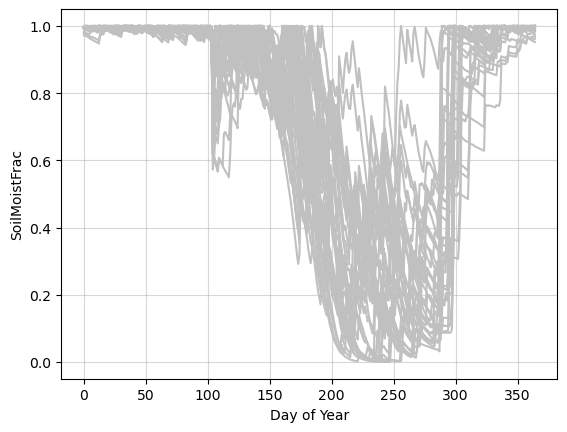

In [52]:
# Plot
fig, ax = plt.subplots()
ax.set_title("")
ax.grid(alpha=0.5)

for ensemble in df.ensemble.unique():
    df_ens = df[df.ensemble == ensemble]
    for model in df_ens.model.unique():
        if ensemble in ["NEX-GDDP", "LOCA"]:
            ax.plot(df_ens[df_ens.model == model]["soilMoistFrac"], color="silver")
        elif ensemble == "OakRidge":
            for method in df_ens[df_ens.model == model].method.unique():
                ax.plot(df_ens[(df_ens.model == model) & (df_ens.method == method)]["soilMoistFrac"], color="silver")

ax.set_ylabel("SoilMoistFrac")
ax.set_xlabel("Day of Year")
plt.show()

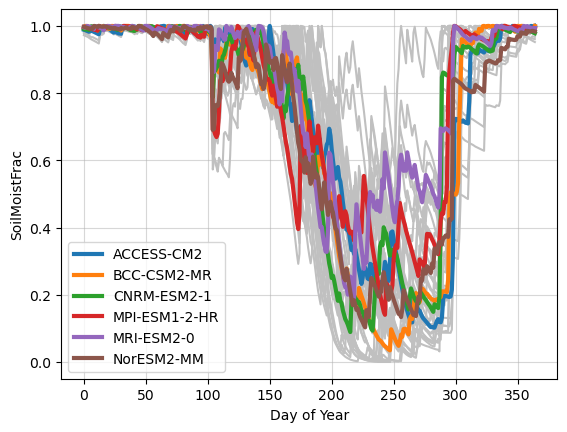

In [53]:
# Plot model means
fig, ax = plt.subplots()
ax.set_title("")
ax.grid(alpha=0.5)

# Add model means
df_model_means = df.groupby(["model","time"])[["soilMoistFrac"]].mean().reset_index()
for model in df_model_means.model.unique():
    ax.plot(np.arange(len(df_model_means[df_model_means.model == model])),
            df_model_means[df_model_means.model == model]["soilMoistFrac"],
            label=model,
            lw=3,
            zorder=10)
    
ax.legend()

for ensemble in df.ensemble.unique():
    df_ens = df[df.ensemble == ensemble]
    for model in df_ens.model.unique():
        if ensemble in ["LOCA", "NEX-GDDP"]:
            ax.plot(df_ens[df_ens.model == model]["soilMoistFrac"], color="silver")
        elif ensemble == "OakRidge":
            for method in df_ens[df_ens.model == model].method.unique():
                ax.plot(df_ens[(df_ens.model == model) & (df_ens.method == method)]["soilMoistFrac"], color="silver")

ax.set_ylabel("SoilMoistFrac")
ax.set_xlabel("Day of Year")
plt.show()

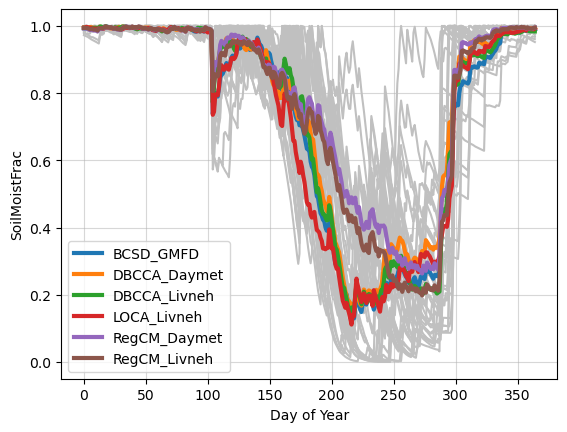

In [54]:
# Plot model means
fig, ax = plt.subplots()
ax.set_title("")
ax.grid(alpha=0.5)

# Add method means
df_method_means = df.groupby(["method","time"])[["soilMoistFrac"]].mean().reset_index()
for method in df_method_means.method.unique():
    ax.plot(np.arange(len(df_model_means[df_model_means.model == model])),
            df_method_means[df_method_means.method == method]["soilMoistFrac"],
            label=method,
            lw=3,
            zorder=10)
    
ax.legend()

for ensemble in df.ensemble.unique():
    df_ens = df[df.ensemble == ensemble]
    for model in df_ens.model.unique():
        if ensemble in ["LOCA", "NEX-GDDP"]:
            ax.plot(df_ens[df_ens.model == model]["soilMoistFrac"], color="silver")
        elif ensemble == "OakRidge":
            for method in df_ens[df_ens.model == model].method.unique():
                ax.plot(df_ens[(df_ens.model == model) & (df_ens.method == method)]["soilMoistFrac"], color="silver")

ax.set_ylabel("SoilMoistFrac")
ax.set_xlabel("Day of Year")
plt.show()

# Compound Extremes

## SSP5-8.5

In [6]:
# Info for all
ssp = "ssp585"

model_infos = [{"model": "ACCESS-CM2", "member": "r1i1p1f1"},
               {"model": "BCC-CSM2-MR", "member": "r1i1p1f1"},
               {"model": "CNRM-ESM2-1", "member": "r1i1p1f2"},
               {"model": "MPI-ESM1-2-HR", "member": "r1i1p1f1"},
               {"model": "MRI-ESM2-0", "member": "r1i1p1f1"},
              {"model": "NorESM2-MM", "member": "r1i1p1f1"}]

methods = ["DBCCA_Daymet", "RegCM_Daymet", "DBCCA_Livneh", "RegCM_Livneh"]

coords = [lat,lon]

year_start, year_end = 2030, 2059

In [7]:
# Read all tmax
var_id = "tasmax"

delayed = []
for ensemble in ["LOCA2", "NEX-GDDP", "OakRidge"]:
    for model_info in model_infos:
        model = model_info["model"]
        member = model_info["member"]
        for year in range(year_start, year_end+1):
            # Okr
            if ensemble == "OakRidge":
                for method in methods:
                    df_tmp = dask.delayed(read_nc)(ensemble, model, member, method, ssp, year, var_id, coords, wbm_path)
                    delayed.append(df_tmp)
            else:
                df_tmp = dask.delayed(read_nc)(ensemble, model, member, None, ssp, year, var_id, coords, wbm_path)
                delayed.append(df_tmp)

In [8]:
# All
df = pd.concat(dask.compute(*delayed))

In [9]:
# Read all soilM
var_id = "soilMoistFrac"

delayed = []
for ensemble in ["LOCA2", "NEX-GDDP", "OakRidge"]:
    for model_info in model_infos:
        model = model_info["model"]
        member = model_info["member"]
        for year in range(year_start, year_end+1):
            # Okr
            if ensemble == "OakRidge":
                for method in methods:
                    df_tmp = dask.delayed(read_nc)(ensemble, model, member, method, ssp, year, var_id, coords, wbm_path)
                    delayed.append(df_tmp)
            else:
                df_tmp = dask.delayed(read_nc)(ensemble, model, member, None, ssp, year, var_id, coords, wbm_path)
                delayed.append(df_tmp)
                
# Join
df_soilM = pd.concat(dask.compute(*delayed))

In [10]:
# Merge
df_all = pd.merge(df, df_soilM)

In [42]:
# Select growing season
df_gs = df_all[df_all.time.dt.month.isin([4,5,6,7,8,9])].copy().reset_index()

In [43]:
# Add year 
df_gs["year"] = df_gs["time"].dt.year

In [44]:
# Store
df_gs.to_csv("./champaign_ssp585_tasmax_soilM.csv", index=False)

In [273]:
# count days per year with frac <= 0.1 and tasmax >= 29
df_plot = df_gs.groupby(["year", "method", "model"]).apply(
    lambda x: ((x["soilMoistFrac"] <= 0.1) & (x["tasmax"] >= 29.0)).sum()).reset_index(name="days")

In [274]:
# mid-century
df_plot_midC = df_plot.query("year >= 2040 and year <= 2059").copy()

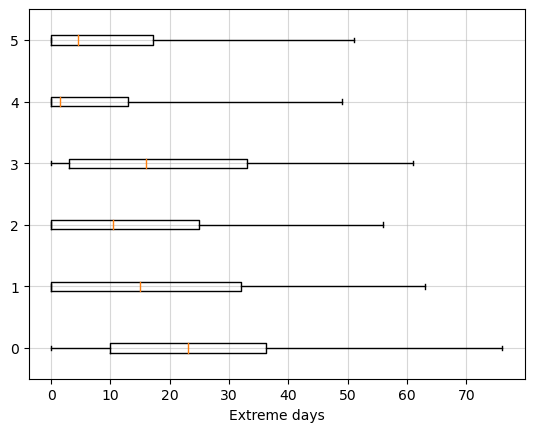

In [275]:
# Make plot
fig, ax = plt.subplots()
ax.set_title("")
ax.grid(alpha=0.5)

# for model in df_plot_midC.model.unique():
#     df_tmp = df_plot_midC[(df_plot_midC.model == model)].sort_values(by="year")
#     ax.hist(df_tmp["days"], histtype='step')
    
for idx, method in enumerate(df_plot_midC.method.unique()):
    df_tmp = df_plot_midC[(df_plot_midC.method == method)].sort_values(by="year")
    ax.boxplot(x = df_tmp["days"],
               positions = [idx],
               whis=(0,100),
               vert=False,
              )
    # df_tmp["days"].plot.kde(ax=ax)

ax.set_xlabel("Extreme days")
# ax.set_xlabel("Year")
plt.show()

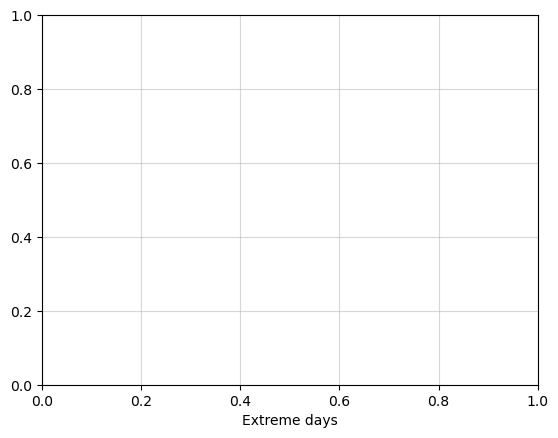

In [270]:
# Make plot
fig, ax = plt.subplots()
ax.set_title("")
ax.grid(alpha=0.5)

# for model in df_plot_midC.model.unique():
#     df_tmp = df_plot_midC[(df_plot_midC.model == model)].sort_values(by="year")
#     ax.hist(df_tmp["days"], histtype='step')
    
for method in df_plot_midC.method.unique():
    df_tmp = df_plot_midC[(df_plot_midC.method == method)].sort_values(by="year")
    # ax.hist(df_tmp["days"], histtype='step', cumulative=True, bins=40, density=True)
    # df_tmp["days"].plot.kde(ax=ax)
    

ax.set_xlabel("Extreme days")
# ax.set_xlabel("Year")
plt.show()

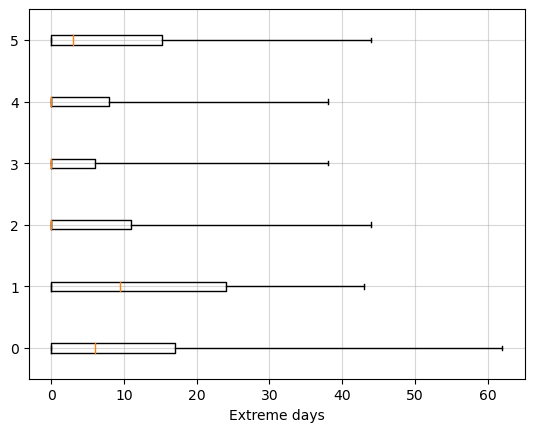

In [271]:
# Make plot
fig, ax = plt.subplots()
ax.set_title("")
ax.grid(alpha=0.5)

for idx, model in enumerate(df_plot_midC.model.unique()):
    df_tmp = df_plot_midC[(df_plot_midC.model == model)].sort_values(by="year")
    # ax.hist(df_tmp["days"], histtype='step', cumulative=True, bins=40, density=True)
    ax.boxplot(x = df_tmp["days"],
               positions = [idx],
               whis=(0,100),
               vert=False,
              )
    # df_tmp["days"].plot.kde(ax=ax)
    
# for method in df_plot_midC.method.unique():
#     df_tmp = df_plot_midC[(df_plot_midC.method == method)].sort_values(by="year")
#     ax.hist(df_tmp["days"], histtype='step')

ax.set_xlabel("Extreme days")
# ax.set_xlabel("Year")
plt.show()

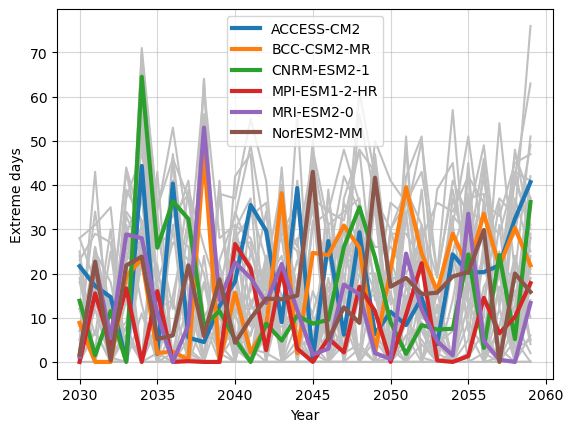

In [121]:
# Make plot
fig, ax = plt.subplots()
ax.set_title("")
ax.grid(alpha=0.5)

# Add model means
df_model_means = df_plot.groupby(["model","year"])[["days"]].mean().reset_index()
for model in df_model_means.model.unique():
    ax.plot(np.arange(2030, 2060),
            df_model_means[df_model_means.model == model]["days"],
            label=model,
            lw=3,
            zorder=10)
    
ax.legend()

for method in df_plot.method.unique():
    for model in df_plot.model.unique():
        df_tmp = df_plot[(df_plot.model == model) & (df_plot.method == method)].sort_values(by="year")
        ax.plot(df_tmp["year"], df_tmp["days"], color="silver")

ax.set_ylabel("Extreme days")
ax.set_xlabel("Year")
plt.show()

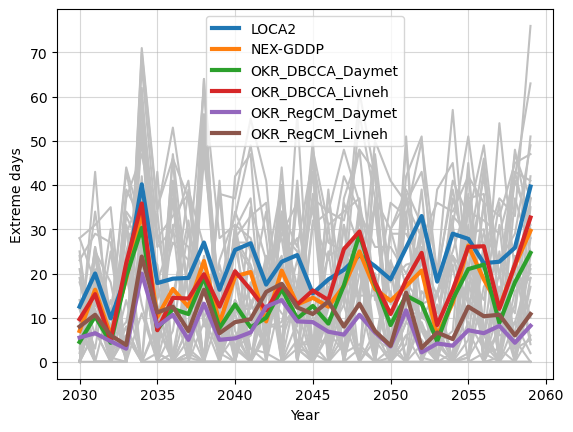

In [122]:
# Make plot
fig, ax = plt.subplots()
ax.set_title("")
ax.grid(alpha=0.5)

# Add model means
df_method_means = df_plot.groupby(["method","year"])[["days"]].mean().reset_index()
for method in df_method_means.method.unique():
    ax.plot(np.arange(2030, 2060),
            df_method_means[df_method_means.method == method]["days"],
            label=method,
            lw=3,
            zorder=10)
    
ax.legend()

for method in df_plot.method.unique():
    for model in df_plot.model.unique():
        df_tmp = df_plot[(df_plot.model == model) & (df_plot.method == method)].sort_values(by="year")
        ax.plot(df_tmp["year"], df_tmp["days"], color="silver")

ax.set_ylabel("Extreme days")
ax.set_xlabel("Year")
plt.show()

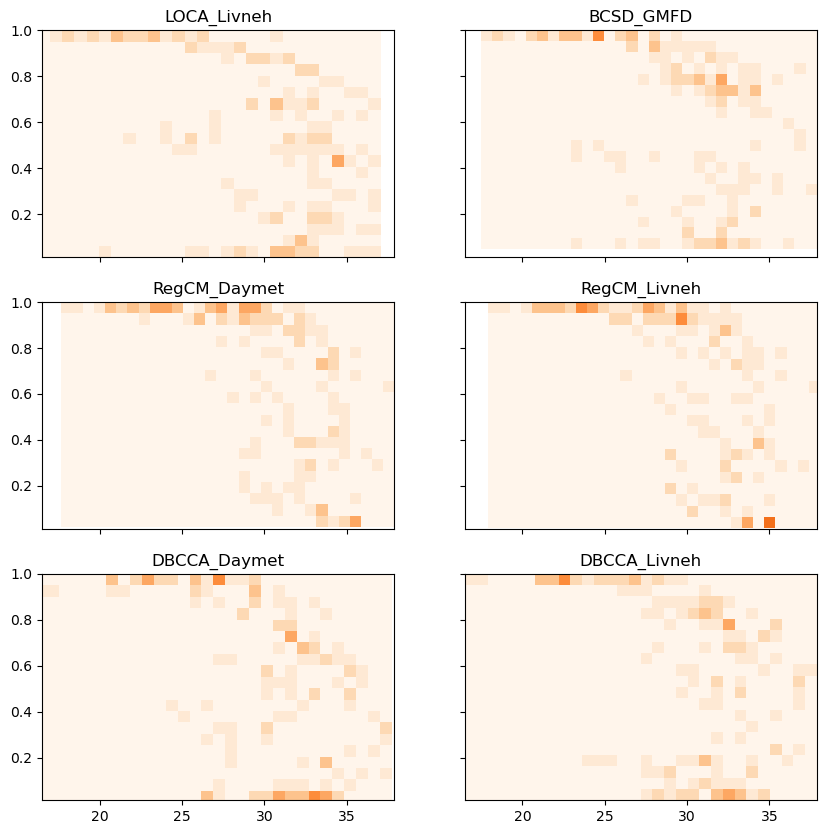

In [143]:
fig, axs = plt.subplots(3,2, figsize=(10,10), sharex=True, sharey=True)
axs = axs.flatten()

model = "CNRM-ESM2-1"
df_model = df_gs[df_gs.model == model]

for idx, method in enumerate(df_model.method.unique()):
    df_plot = df_model[df_model.method == method]
    axs[idx].hist2d(x = df_plot["tasmax"],
                    y = df_plot["soilMoistFrac"],
                    bins=[30,20],
                    vmin=0., vmax=10.,
                    cmap="Oranges")
    axs[idx].set_title(method)

plt.show()